# Google Stock Price Data
Train dataset contains daily stock trade data from 3/1/2012 to 30/12/2016. Some days' data is missing  
Test dataset contains stock trade data from 3/1/2017 to 31/1/2017

In [1]:
import numpy as np
import pandas as pd
ds_train = pd.read_csv('Google_Stock_Price_Train.csv')
ds_train.head()

Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

In [2]:
len(ds_train)

1258

In [3]:
ds_test = pd.read_csv('Google_Stock_Price_Test.csv')
ds_test.tail()

Date    Open    High     Low   Close     Volume
15  1/25/2017  829.62  835.77  825.06  835.67  1,494,500
16  1/26/2017  837.81  838.00  827.01  832.15  2,973,900
17  1/27/2017  834.71  841.95  820.44  823.31  2,965,800
18  1/30/2017  814.66  815.84  799.80  802.32  3,246,600
19  1/31/2017  796.86  801.25  790.52  796.79  2,160,600

In [4]:
len(ds_test)

20

Starting date of train data

In [5]:
from datetime import datetime
d1 = datetime.strptime(ds_train['Date'][0], "%m/%d/%Y")
d2 = datetime.strptime(ds_train['Date'][len(ds_train)-1], "%m/%d/%Y")
d1

datetime.datetime(2012, 1, 3, 0, 0)

Ending date of train data

In [6]:
d2

datetime.datetime(2016, 12, 30, 0, 0)

No of days between start date and end date

In [7]:
(d2-d1).days

1823

Datatypes in dataframe

In [8]:
ds_train.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

In [9]:
ds_test.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

## Preprocess: Convert American notations to numpy types
Converting numbers in american notations to numpy types

In [10]:
try:
    ds_train['Close'] = ds_train['Close'].str.replace(',', '').astype(float)
except AttributeError as e:
    pass
try:
    ds_train['Volume'] = ds_train['Volume'].str.replace(',', '').astype(int)
except AttributeError as e:
    pass
try:
    ds_test['Volume'] = ds_test['Volume'].str.replace(',', '').astype(int)
except AttributeError as e:
    pass

ds_train.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

## Add feature: Ordinal Date
To fill out missing days, a column representing number of days passed relative to the start date will be of help

In [11]:
date_format = "%m/%d/%Y"
day1 = datetime.strptime(ds_train['Date'][0], date_format)
def dates_to_ordinal(row, day1):
    return (datetime.strptime(row['Date'], date_format) - day1).days
ds_train['Ordinal Date'] = pd.Series(ds_train.apply(dates_to_ordinal, axis=1, args=(day1,)), index=ds_train.index)
ds_train = ds_train.set_index('Ordinal Date')
ds_train.head()

Date    Open    High     Low   Close    Volume
Ordinal Date                                                    
0             1/3/2012  325.25  332.83  324.97  663.59   7380500
1             1/4/2012  331.27  333.87  329.08  666.45   5749400
2             1/5/2012  329.83  330.75  326.89  657.21   6590300
3             1/6/2012  328.34  328.77  323.68  648.24   5405900
6             1/9/2012  322.04  322.29  309.46  620.76  11688800

In [12]:
ds_test['Ordinal Date'] = ds_test.apply(dates_to_ordinal, axis=1, args=(day1,))
ds_test = ds_test.set_index('Ordinal Date')
ds_test.head()

Date    Open    High     Low   Close   Volume
Ordinal Date                                                   
1827          1/3/2017  778.81  789.63  775.80  786.14  1657300
1828          1/4/2017  788.36  791.34  783.16  786.90  1073000
1829          1/5/2017  786.08  794.48  785.02  794.02  1335200
1830          1/6/2017  795.26  807.90  792.20  806.15  1640200
1833          1/9/2017  806.40  809.97  802.83  806.65  1272400

In [13]:
sample = ds_train.loc[2:6]
sample

Date    Open    High     Low   Close    Volume
Ordinal Date                                                    
2             1/5/2012  329.83  330.75  326.89  657.21   6590300
3             1/6/2012  328.34  328.77  323.68  648.24   5405900
6             1/9/2012  322.04  322.29  309.46  620.76  11688800

A function to fill in missing values of the timeseries

In [14]:
from datetime import timedelta
def filler(row1, row2, row1_index, row2_index):
    n = row2_index - row1_index
    filler_rows = []
    diff_row = {
        'Open': (row2['Open'] - row1['Open']) / n,
        'High': (row2['High'] - row1['High']) / n,
        'Low': (row2['Low'] - row1['Low']) / n,
        'Close': (row2['Close'] - row1['Close']) / n,
        'Volume': (row2['Volume'] - row1['Volume']) // n,
        
    }
    for i in range(1, n):
        date = datetime.strptime(row1['Date'], date_format)
        date += timedelta(days=i)
        filler_rows += [
            {
                'Date': date.strftime(date_format),
                'Open': row1['Open'] + i * diff_row['Open'],
                'High': row1['High'] + i * diff_row['High'],
                'Low': row1['Low'] + i * diff_row['Low'],
                'Close': row1['Close'] + i * diff_row['Close'],
                'Volume': row1['Volume'] + i * diff_row['Volume'],
                'Ordinal Date': row1_index + i
            }
        ]
    filler_df = pd.DataFrame(filler_rows).set_index('Ordinal Date')
    return pd.DataFrame(filler_df)

# Show a sample filler
row1 = ds_train.iloc[3]
row2 = ds_train.iloc[6]
filler(row1, row2, 3, 6)

Date        Open        High     Low       Close   Volume
Ordinal Date                                                                 
4             01/07/2012  322.423333  323.686667  318.92  640.243333  5209866
5             01/08/2012  316.506667  318.603333  314.16  632.246667  5013832

In [15]:
ds_complete = pd.concat([ds_train, ds_test])
i = 0
fillers_list = []
while True:
    if not i < (len(ds_complete) - 1):
        break
    current = ds_complete.index[i]
    nex = ds_complete.index[i+1]
    delta = nex - current
    if delta > 1:
        fillers_list.append(filler(ds_complete.loc[current], ds_complete.loc[nex], current, nex))
    i += 1
fillers_list.append(ds_complete)
ds_complete = pd.concat(fillers_list).sort_index(axis=0)
ds_complete.head()

Date    Open    High     Low   Close   Volume
Ordinal Date                                                     
0               1/3/2012  325.25  332.83  324.97  663.59  7380500
1               1/4/2012  331.27  333.87  329.08  666.45  5749400
2               1/5/2012  329.83  330.75  326.89  657.21  6590300
3               1/6/2012  328.34  328.77  323.68  648.24  5405900
4             01/07/2012  326.24  326.61  318.94  639.08  7500200

In [16]:
ds_complete.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855],
           dtype='int64', name='Ordinal Date', length=1856)

## Save preprocessed dataset

In [17]:
ds_complete.to_csv('Google_Stock_Price_Preprocessed.csv')

## Scaling

In [18]:
from sklearn.preprocessing import StandardScaler
test_break_index = 1827
end_break_index = len(ds_complete)
scaler = StandardScaler()
ds_train = ds_complete.iloc[:1827, 1:].to_numpy(dtype='float')
ds_train = scaler.fit_transform(ds_train)
ds_train_x = np.array([ds_train[:-1]])
ds_train_y = np.array([ds_train[1:]])
ds_test = ds_complete.iloc[1827:, 1:].to_numpy(dtype='float')
ds_train[:5]

array([[-1.3716429 , -1.33901625, -1.35432344, -0.29793423,  1.8203216 ],
       [-1.33201479, -1.33222029, -1.32703502, -0.28059115,  1.10917401],
       [-1.34149394, -1.35260816, -1.34157556, -0.33662265,  1.47580022],
       [-1.35130223, -1.36554662, -1.36288841, -0.39101687,  0.95941054],
       [-1.36512598, -1.3796613 , -1.39435972, -0.44656325,  1.87250992]])

x is a batch of single timeseries containing 1826 timesteps of 5 features

In [19]:
ds_train_x.shape

(1, 1826, 5)

Shape of y mimics shape of x

In [20]:
ds_train_y.shape

(1, 1826, 5)

In [26]:
import tensorflow as tf
from tensorflow import keras

inputs = keras.Input(batch_shape=(1, None, 5))
lstm = keras.layers.LSTM(5, return_sequences=True, activation=None)(inputs)
model = keras.Model(inputs, lstm)
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
)
model.fit(ds_train_x, ds_train_y, epochs=50, batch_size=1)

Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 7.2711
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 1.0202
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.9661
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.9420
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.9314
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.9269
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.9231
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.9183
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.9121
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 0.9041
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.8940
Epoch 12/50
1/1 [==============================] - 0s 1ms/step - loss: 0.8817
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 0.

In [30]:
seed_size = 200
seed = ds_train_y[:, -seed_size:, :]
forecast_size = end_break_index - test_break_index
for t in range(forecast_size):
    seed = np.concatenate([seed, model.predict(seed)[:, -1:, :]], axis=1)
forecast = scaler.inverse_transform(seed[0, -forecast_size:, :])

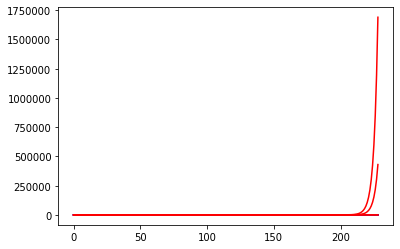

In [34]:
import matplotlib.pyplot as plt
seed_unscaled = scaler.inverse_transform(seed[0, :seed_size])
plt.plot(np.concatenate([seed_unscaled[:, 0:4], ds_test[:, 0:4]], axis=0), c="blue")
plt.plot(np.concatenate([seed_unscaled[:, 0:4], forecast[:, 0:4]], axis=0), c="red")

In [32]:
forecast

array([[5.34821811e+02, 8.52386430e+02, 7.48175716e+02, 8.11208020e+02,
        1.58340489e+06],
       [5.29375486e+02, 9.36752012e+02, 6.73403517e+02, 8.61675422e+02,
        2.34856564e+06],
       [5.13675901e+02, 1.03705017e+03, 7.10517148e+02, 8.41996149e+02,
        2.63474598e+06],
       [5.16075845e+02, 1.12060205e+03, 7.31338961e+02, 8.65151129e+02,
        2.87042659e+06],
       [5.19221815e+02, 1.23567554e+03, 7.82984939e+02, 8.77854602e+02,
        3.03921231e+06],
       [5.25209911e+02, 1.39160956e+03, 8.41383000e+02, 9.12129447e+02,
        3.17915196e+06],
       [5.29206412e+02, 1.61883914e+03, 9.29273933e+02, 9.45542504e+02,
        3.29487217e+06],
       [5.32003454e+02, 1.94766268e+03, 1.03487972e+03, 9.91682889e+02,
        3.41819005e+06],
       [5.33166691e+02, 2.42983230e+03, 1.18807284e+03, 1.02842275e+03,
        3.54650123e+06],
       [5.33553181e+02, 3.12661803e+03, 1.38708081e+03, 1.06059178e+03,
        3.71574864e+06],
       [5.33614771e+02, 4.1129